In [1]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

Using device: cuda


We want to see how the morphology of the network affects the speed of learning. 

For this we have trained 6 different dendritic architectures that differ in their width/depth. We want to keep the total number of parameters roughly the same across all networks, so as we increase network depth we also decrease network width. 

We trained 4 instances of the same model. The first instance of a 2 layer network has the name: `unconditional-dendritic-2-layers_1`. 

In [11]:
from utils import select_model

list_of_layer_depths = [2, 4, 5, 6, 7, 10]  # number of layers
list_of_models = ['unconditional-dendritic-' + str(l) + '-layers-l1-reg-0.1' for l in list_of_layer_depths]
print(list_of_models)

from utils import load_model_weights_from_chkpt
model, num_steps, ambient_dims = load_model_weights_from_chkpt(list_of_models[0], model_num=1, epoch_number=0)
print(model)

['unconditional-dendritic-2-layers-l1-reg-0.1', 'unconditional-dendritic-4-layers-l1-reg-0.1', 'unconditional-dendritic-5-layers-l1-reg-0.1', 'unconditional-dendritic-6-layers-l1-reg-0.1', 'unconditional-dendritic-7-layers-l1-reg-0.1', 'unconditional-dendritic-10-layers-l1-reg-0.1']
model loaded!
VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
  )
)


In [12]:
'''
import json
from utils import load_model_description

json_savedir = os.path.join(base_dir, 'core/model_description')

model_version_numbers = np.arange(1, 6)
for model_name in list_of_models:
    for v in model_version_numbers:
        # change the key "model_version" to "model_number"
        d = load_model_description(model_name, v)
        model_details = {"model_number" if k == "model_version" else k:v for k,v in d.items()}

        # now save this dict to the same json file
        model_name_and_number = f'{model_name}_{v}'
        json_name = f'{model_name_and_number}.json'
        with open(os.path.join(json_savedir, json_name), 'w') as file:
            json.dump(model_details, file)        
'''

'\nimport json\nfrom utils import load_model_description\n\njson_savedir = os.path.join(base_dir, \'core/model_description\')\n\nmodel_version_numbers = np.arange(1, 6)\nfor model_name in list_of_models:\n    for v in model_version_numbers:\n        # change the key "model_version" to "model_number"\n        d = load_model_description(model_name, v)\n        model_details = {"model_number" if k == "model_version" else k:v for k,v in d.items()}\n\n        # now save this dict to the same json file\n        model_name_and_number = f\'{model_name}_{v}\'\n        json_name = f\'{model_name_and_number}.json\'\n        with open(os.path.join(json_savedir, json_name), \'w\') as file:\n            json.dump(model_details, file)        \n'

now load the first instance of each architecture

In [13]:
epoch_number = 190000

models = []
for model in list_of_models:
    model, num_steps, ambient_dims = load_model_weights_from_chkpt(model, model_num=1, epoch_number=epoch_number)
    models.append(model)

model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!


see how the generated samples look like after 15e5 training epochs, sorted by number of dendritic layers

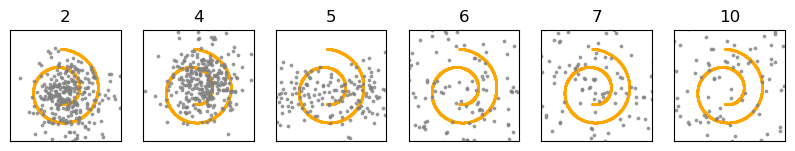

In [14]:
# now generate samples from all models for a given epoch
lim = 1.5
lims = [-lim, lim]
sample_size = int(3e2)
from prior_utils import p_sample_loop
from dataset_utils import generate_2d_swiss_roll
gt_manifold = generate_2d_swiss_roll(int(1e3), True, return_as_tensor=True)[1]

fig, ax = plt.subplots(1, len(models), figsize=(10,2))
for i, model in enumerate(models):
    model.to(device)
    x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
    x_rev = x_rev.cpu().detach().numpy()
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*x_rev[-1].T, s=3, alpha=0.7, color='grey')
    ax[i].set(title=f'{list_of_layer_depths[i]}')
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xlim=lims, ylim=lims)
        remove_all_ticks_and_labels(a)
    

# analyzing the effect of l1 regularization

In [60]:
from utils import select_model

layer_depth = 2
epoch_number = 100000

l1_lambdas = [1, 0.5, 0.2, 0.1, 0.01, 0.001, 0]
list_of_model_names = [f'unconditional-dendritic-{layer_depth}-layers-l1-reg-{l}' for l in l1_lambdas[1:-1]]

from utils import load_model_weights_from_chkpt
models = []
for i, model_name in enumerate(list_of_model_names):
    model, num_steps, ambient_dims = load_model_weights_from_chkpt(model_name, model_num=1, epoch_number=epoch_number)
    models.append(model)

# for l1_lambda = 0
model_name = f'unconditional-dendritic-{layer_depth}-layers'
list_of_model_names.append(model_name)
model, _, _ = load_model_weights_from_chkpt(model_name, model_num=10, epoch_number=epoch_number)
models.append(model)

# for l1_lambda = 1
model_name = f'unconditional-dendritic-{layer_depth}-layers-l1-reg'
list_of_model_names.insert(0, model_name)
model, _, _ = load_model_weights_from_chkpt(model_name, model_num=1, epoch_number=epoch_number)
models.insert(0, model)

print(list_of_model_names)

model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
['unconditional-dendritic-2-layers-l1-reg', 'unconditional-dendritic-2-layers-l1-reg-0.5', 'unconditional-dendritic-2-layers-l1-reg-0.2', 'unconditional-dendritic-2-layers-l1-reg-0.1', 'unconditional-dendritic-2-layers-l1-reg-0.01', 'unconditional-dendritic-2-layers-l1-reg-0.001', 'unconditional-dendritic-2-layers']


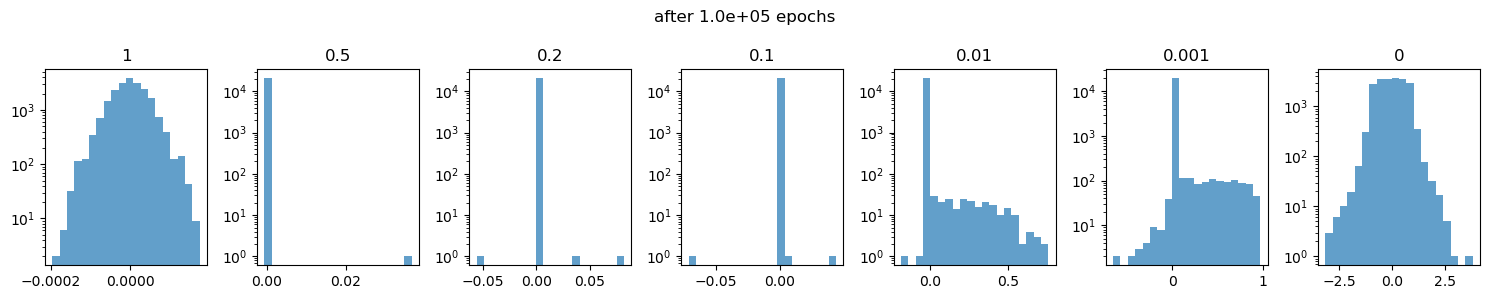

In [61]:
# histogram of the weights
fig, ax = plt.subplots(1, len(models), figsize=(15, 3))

for i, model in enumerate(models):
    weights = model.features[0].linear.weight.cpu().detach().numpy()
    ax[i].hist(weights.flatten(), bins=20, alpha=0.7)
    ax[i].set(title=f'{l1_lambdas[i]}', yscale='log')
fig.suptitle(f'after {epoch_number:.1e} epochs')
fig.tight_layout()

In [70]:
# we can extract the weights that are not sparse:
l1_lambda = 0.01
idx = l1_lambdas.index(l1_lambda)
model_name = list_of_model_names[idx]
print(model_name)
model = models[idx]

weights = model.features[0].linear.weight.cpu().detach().numpy()
print(weights.shape)
non_sparse_weights = np.array(np.where(weights > 0.02)).T
print(non_sparse_weights.T)

unconditional-dendritic-2-layers-l1-reg-0.01
(6962, 3)
[[ 357  361  367  373  375  383  387  396  597  598  605  611  620  621
   623  626  628  633  635  637  642  651  654  655  667  681  691  692
   698  700  703  705  952  957  960  967  982  983  999 1183 1187 1195
  1199 1205 1207 1210 1217 1221 1223 1226 1993 2000 2184 2208 2211 2219
  2223 2225 2227 2233 2238 2240 2898 2903 2908 2910 2914 2931 2936 2939
  2940 2945 3388 3394 3406 3407 3413 3418 3600 3610 3611 3614 3617 3620
  3622 3627 3628 3633 3641 3647 3657 3736 3739 3740 3749 3750 3752 3755
  3766 3907 3914 3919 3921 3934 3942 3951 4080 4081 4085 4101 4106 4107
  4112 4119 4121 4128 4456 4464 4732 4742 4744 4747 4750 4761 4765 4771
  4844 4894 4960 4967 4974 4978 4988 4989 4991 4993 5001 5003 5006 5007
  5009 5144 5156 5159 5163 5182 5188 5189 5251 5252 5265 5274 5275 5280
  5282 5283 5285 5288 5293 5296 5300 5436 5447 5472 5478 5553 5555 5558
  5570 5589 5600 5624 5631 5639 5649 5959 5960 5970 5971 5988 5989 6004
  6007 60

note how most of these weights are related to the 3rd input. This is because the 3rd input is the one that is feeding in the phase information

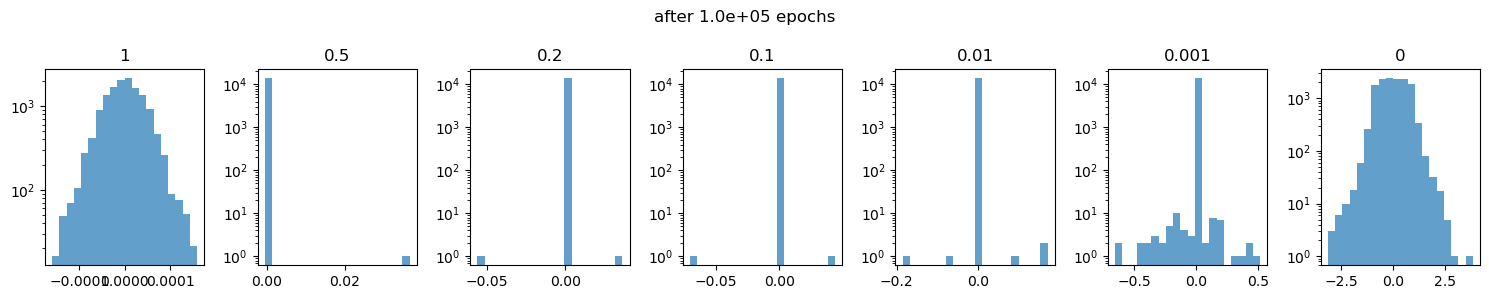

In [68]:
# histogram of the weights, but only the inputs from the neurons, not the phase
fig, ax = plt.subplots(1, len(models), figsize=(15, 3))

for i, model in enumerate(models):
    weights = model.features[0].linear.weight[:, :2].cpu().detach().numpy()
    ax[i].hist(weights.flatten(), bins=20, alpha=0.7)
    ax[i].set(title=f'{l1_lambdas[i]}', yscale='log')
fig.suptitle(f'after {epoch_number:.1e} epochs')
fig.tight_layout()

In [ ]:
# can we get a sense of which subunits are getting connections? Is it only one of the neurons? Or both? Or only one part of the dendritic branch?
# we can calculate which branches correspond to which branches of the dendritic tree, i.e. leaves 4485 corresponds to branch [4/7, 2/7, 6/7, 1/7, 1/2] etc

def get_lineage(leaves, num_neurons, branch_cfg):
    ancestors = []
    return ancestors

We want to see whether the morphology of the architecture affects the speed at which the network is able to learn the underlying dataset. 

We generated many samples from each network throughout their learning process. We can quantify how well they've learned the distribution by calculating the KL divergence between the ground truth manifold and the generated samples. The higher the KL divergence, the less similar the generated samples are to the ground truth dataset. 

In [30]:
import zarr

data_base_dir = os.path.join(base_dir, 'core/saved_arrays')

# eval_epochs = [i for i in range(0, int(1e5), int(1e4))]
eval_epochs = [i for i in range(0, int(15e5), int(1e5))]
# eval_epochs.append(int(15e5-1e4))

skip the below

In [31]:
def load_samples_from_file(depth, model_iteration, chkpt_num):
    data_dir = os.path.join(data_base_dir, 'samples', f'unconditional-dendritic-{depth}-layers_{model_iteration}', 'by_checkpoints', str(chkpt_num), 'prior-iid-unimodal')
    # samples = zarr.load(os.path.join(data_dir, 'num_samples=5e+04-num_runs=1-batch_idx=0', 'x_revs-run_num=0.zarr'))
    samples = zarr.load(os.path.join(data_dir, 'num_samples=5e+04-num_runs=1-batch_idx=0', 'x-run_num=0.zarr'))
    return samples

instance = 1
model_instances = [1, 2, 3, 4]
model_instances = [10, 11]

for chkpt_num in eval_epochs:
    print('epoch', chkpt_num)
    samples_by_depth = []
    for depth in list_of_layer_depths:
        print('    depth', depth)
        samples_by_instance = []
        for model_instance in model_instances:
            samples = load_samples_from_file(depth, model_instance, chkpt_num)
            print(samples.shape)
            samples_by_instance.append(samples)
        samples_by_instance = np.stack(samples_by_instance)
        samples_by_depth.append(samples_by_instance)
    samples_by_depth = np.stack(samples_by_depth)
    zarr.save(os.path.join(data_base_dir, 'morphology_all_models', f'epoch={chkpt_num}'), samples_by_depth)
    print(f'epoch {chkpt_num} saved!')

epoch 0
    depth 2
(50000, 2)
(50000, 2)
    depth 4
(50000, 2)
(50000, 2)
    depth 5
(50000, 2)
(50000, 2)
    depth 6
(50000, 2)
(50000, 2)
    depth 7
(50000, 2)
(50000, 2)
    depth 10
(50000, 2)
(50000, 2)
epoch 0 saved!
epoch 100000
    depth 2
(50000, 2)
(50000, 2)
    depth 4
(50000, 2)
(50000, 2)
    depth 5
(50000, 2)
(50000, 2)
    depth 6
(50000, 2)
(50000, 2)
    depth 7
(50000, 2)
(50000, 2)
    depth 10
(50000, 2)
(50000, 2)
epoch 100000 saved!
epoch 200000
    depth 2
(50000, 2)
(50000, 2)
    depth 4
(50000, 2)
(50000, 2)
    depth 5
(50000, 2)
(50000, 2)
    depth 6
(50000, 2)
(50000, 2)
    depth 7
(50000, 2)
(50000, 2)
    depth 10
(50000, 2)
(50000, 2)
epoch 200000 saved!
epoch 300000
    depth 2
(50000, 2)
(50000, 2)
    depth 4
(50000, 2)
(50000, 2)
    depth 5
(50000, 2)
(50000, 2)
    depth 6
(50000, 2)
(50000, 2)
    depth 7
(50000, 2)
(50000, 2)
    depth 10
(50000, 2)
(50000, 2)
epoch 300000 saved!
epoch 400000
    depth 2
(50000, 2)
(50000, 2)
    depth 4

In [16]:
# keep only the samples from the last time step
for chkpt_num in eval_epochs:
    print(chkpt_num)
    data_dir = os.path.join(data_base_dir, 'morphology_all')
    samples = zarr.load(os.path.join(data_dir, f'epoch={chkpt_num}'))
    samples_last_idx = samples[:, :, 100, :, :]
    zarr.save(os.path.join(data_base_dir, 'morphology', f'epoch={chkpt_num}'), samples_last_idx)

0
100000


KeyboardInterrupt: 

In [37]:
# gather the morphology and morphology_later_models into a single array
for chkpt_num in eval_epochs:
    morphology_array = zarr.load(os.path.join(data_base_dir, 'morphology', f'epoch={chkpt_num}'))
    # print(morphology_array.shape)
    morphology_later_models_array = zarr.load(os.path.join(data_base_dir, 'morphology_later_models', f'epoch={chkpt_num}'))
    # print(morphology_later_models_array.shape)
    
    combined_morphology = np.concatenate([morphology_array, morphology_later_models_array], axis=1)
    print(combined_morphology.shape)
    zarr.save(os.path.join(data_base_dir, 'morphology_combined', f'epoch={chkpt_num}'), combined_morphology)


(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)
(6, 6, 50000, 2)


Ignore the above

In [38]:
# now calculate the KL divergence between the generated samples and the ground truth dataset
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 4

# 5e3 samples per model

histograms_by_epoch = []
for epoch in eval_epochs:
    print(epoch)
    data_dir = os.path.join(data_base_dir, 'morphology_combined')
    samples = zarr.load(os.path.join(data_dir, f'epoch={epoch}'))
    print(samples.shape)
    # samples has shape (depths: 6, iterations: 4, samples: 50000, dimensions: 2)

    # now calculate the histogram of samples from the prior
    histogram_by_depth = []
    for d, depth in enumerate(list_of_layer_depths):
        histogram_by_iteration = []
        for i in range(samples.shape[1]):
            histogram = calculate_histogram(samples[d, i], num_bins_per_dim, domain_range)
            histogram_by_iteration.append(histogram)
        histogram_by_iteration = np.stack(histogram_by_iteration)
        histogram_by_depth.append(histogram_by_iteration)
    histogram_by_depth = np.stack(histogram_by_depth)
    histograms_by_epoch.append(histogram_by_depth)
histograms_by_epoch = np.stack(histograms_by_epoch)
print(histograms_by_epoch.shape)
# zarr.save(os.path.join(), histogram_by_depth)

0
(6, 6, 50000, 2)
100000
(6, 6, 50000, 2)
200000
(6, 6, 50000, 2)
300000
(6, 6, 50000, 2)
400000
(6, 6, 50000, 2)
500000
(6, 6, 50000, 2)
600000
(6, 6, 50000, 2)
700000
(6, 6, 50000, 2)
800000
(6, 6, 50000, 2)
900000
(6, 6, 50000, 2)
1000000
(6, 6, 50000, 2)
1100000
(6, 6, 50000, 2)
1200000
(6, 6, 50000, 2)
1300000
(6, 6, 50000, 2)
1400000
(6, 6, 50000, 2)
(15, 6, 6, 15, 15)


In [39]:
from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 5e4
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]
histogram_of_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)
print(histogram_of_dataset.shape)

(15, 15)


In [40]:
from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

kl_by_epoch = []
for e, epoch in enumerate(eval_epochs):
    # histograms_by_epoch has shape (epochs: 16, depths: 6, iterations: 4, dim1: 15, dim2: 15)

    kl_by_depth = []
    for d, depth in enumerate(list_of_layer_depths):

        kl_by_iteration = []
        for i in range(samples.shape[1]):
            # ------------------------------------ iid ----------------------------------- #
            p = histograms_by_epoch[e, d, i] + epsilon  # distribution of model generated samples 
            q = histogram_of_dataset + epsilon  # distribution to compare against

            p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
            q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
            kl_by_iteration.append(entropy(p, q))
        kl_by_iteration = np.stack(kl_by_iteration)
        kl_by_depth.append(kl_by_iteration)
    kl_by_depth = np.stack(kl_by_depth)
    kl_by_epoch.append(kl_by_depth)
kl_by_epoch = np.stack(kl_by_epoch)

print(kl_by_epoch.shape)




(15, 6, 6)


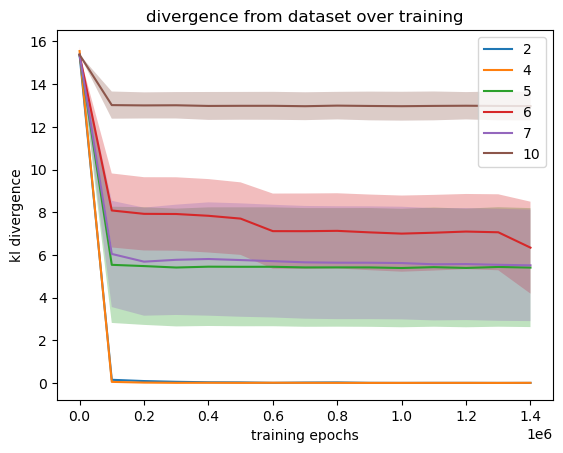

In [41]:
fig, ax = plt.subplots(1, 1)
x = eval_epochs

kl_mean = np.mean(kl_by_epoch, axis=2)
kl_stdev = np.std(kl_by_epoch, axis=2) / np.sqrt(4)
for i in range(len(list_of_layer_depths)):
    ax.plot(eval_epochs, kl_mean[:, i], label=f'{list_of_layer_depths[i]}')
    ax.fill_between(eval_epochs, kl_mean[:,i]+kl_stdev[:,i], kl_mean[:,i]-kl_stdev[:,i], alpha=0.3)
ax.legend()
ax.set(ylabel='kl divergence', xlabel='training epochs', title='divergence from dataset over training')

from plot import save_fig
save_fig(fig, 'supp-morphology')

# number of parameters

In [62]:
model_version = 10

# calculate the num of parameters in each model
from utils import count_parameters
num_parameters = []
num_parameters_in_fc_layer = []
for model_name in list_of_models:
    model, num_steps, ambient_dims = load_model_weights_from_chkpt(model_name, model_num=model_version, epoch_number=0)
    num_parameters_in_fc_layer.append(model.features[0].linear.weight.detach().numpy().flatten().shape[0])
    num_parameters.append(count_parameters(model))

model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!


In [74]:
print('total num parameters:\n', num_parameters)
print('FC parameters:\n', num_parameters_in_fc_layer)
num_parameters_in_arbor = [num_parameters[i] - num_parameters_in_fc_layer[i] for i in range(len(num_parameters))]
print('branch parameters:\n', num_parameters_in_arbor)

total num parameters:
 [35048, 33154, 34372, 34814, 34986, 32234]
FC parameters:
 [20886, 18816, 18750, 18432, 17496, 13824]
branch parameters:
 [14162, 14338, 15622, 16382, 17490, 18410]


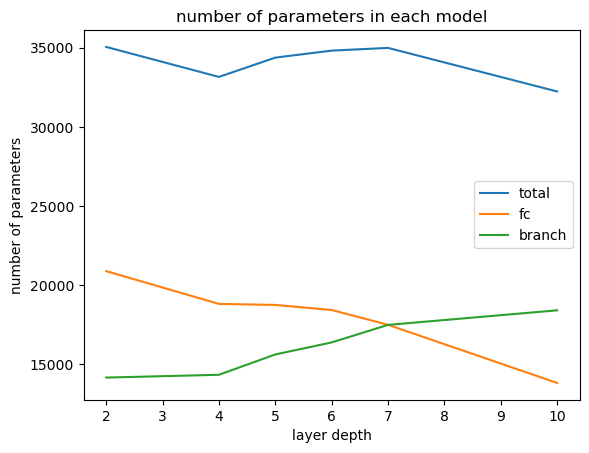

In [76]:
fig, ax = plt.subplots(1, 1)
ax.plot(list_of_layer_depths, num_parameters, label='total')
ax.plot(list_of_layer_depths, num_parameters_in_fc_layer, label='fc')
ax.plot(list_of_layer_depths, num_parameters_in_arbor, label='branch')
ax.set(ylabel='number of parameters', xlabel='layer depth', title='number of parameters in each model')
ax.legend()